1. The M&M seem to be more oval meaning they have a higher eccentricity, using eccentricity could mean that nonstops which are broken would also be detected by as M&Ms by the algorithm.

2. Preprocessing steps taken in order:  
    - Grayscale conversion  
    - Image crop  
    - Mean thresholding  
    - Area_closing  
    - Area_open

3. I intend to extract:  
    - eccentricity
    - axis_major_length

4. I used **watershed** to separate objects as some of the objects close enough to look connected on the thresholded image. Using **flood fill** would not find all the objects I want.

5. Code is provided below.

6. I was able to separate nonstops and M&Ms. A second parameter had to be used for separating broken nonstops and M&Ms.

7. The nonstops and M&Ms were successfully separated but the code is quite slow. It might be possible to speed up the code by changing algorithms or other optimizations.


In [43]:
import skimage.filters as skif
import skimage.measure as skime
import skimage.morphology as skim
import skimage.segmentation as skis
import skimage.feature as skife
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

Removing noise and cleaning up edges...
Closing is done!
Opening is done!


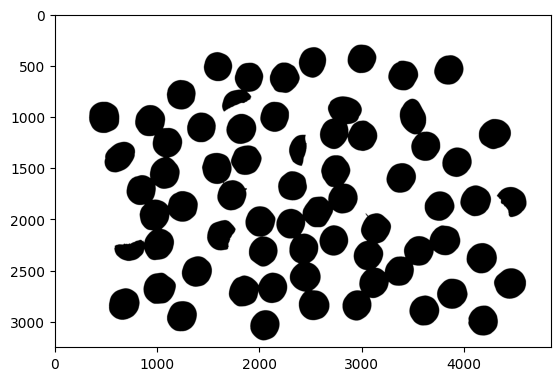

In [42]:
with Image.open(r"C:\Users\Ludvi\OneDrive - Norwegian University of Life Sciences\Emner\3. Tredjeår\INF250\Assignment-2\IMG_2754_nonstop_alltogether.JPG") as figure:
    figure = figure.convert("L")
    figure = figure.crop((350, 150, 5200, 3400))
    img = np.array(figure)

# Mean thresholding, otsu didnt return a good result
threshold = skif.threshold_mean(img)
img[img >= threshold] = 255
img[img < threshold] = 0

print("Removing noise and cleaning up edges...")
# Remove noise and clean up edges
img = skim.area_closing(img, 13000)
print("Closing is done!")
img = skim.area_opening(img, 12000)
print("Opening is done!")
plt.imshow(img, cmap="gray")
plt.show()

In [37]:
print("Watershedding...")
img_binary = np.zeros(img.shape)
img_binary[img == 255] = 0
img_binary[img == 0] = 1

img_binary = np.int64(img_binary)

distance = ndi.distance_transform_edt(img_binary)
localMaximum = skife.peak_local_max(distance, footprint=np.ones((30, 30)), labels=img_binary, min_distance=150)

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(localMaximum.T)] = True
markers = ndi.label(mask)[0]

labels = skis.watershed(-distance, markers, mask=img_binary, watershed_line=True)
properties = skime.regionprops(labels)
print(len(properties))

Watershedding...
68


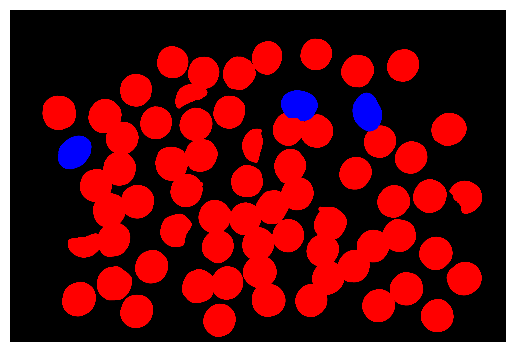

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")

oval_shapes = []
round_shapes = []

# Separate by eccentricity
for regions in properties:
        if regions.eccentricity > 0.6:
                oval_shapes.append(regions)
        else:
                ax.plot(regions.coords[:, 1], regions.coords[:, 0], linewidth=2, color="red")
                round_shapes.append(regions.axis_major_length)

# Filter out broken M&Ms
nonstop_major_axis = sum(round_shapes)/len(round_shapes)
for regions in oval_shapes:
        if (nonstop_major_axis-20 < regions.axis_major_length and regions.axis_major_length < nonstop_major_axis+20):
                ax.plot(regions.coords[:, 1], regions.coords[:, 0], linewidth=2, color="red")
        else:
                ax.plot(regions.coords[:, 1], regions.coords[:, 0], linewidth=2, color="blue")

plt.imshow(labels, cmap="nipy_spectral")
plt.axis("off")
plt.show()